In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
for table in inspector.get_table_names():
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print('   ', column["name"], column["type"])

measurement
    id INTEGER
    station TEXT
    date TEXT
    prcp FLOAT
    tobs FLOAT
station
    id INTEGER
    station TEXT
    name TEXT
    latitude FLOAT
    longitude FLOAT
    elevation FLOAT


In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
first_row = session.query(Measurement).first()
first_row.__dict__



{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a21ca75f8>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [12]:
first_rowS = session.query(Station).first()
first_rowS.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a21cea358>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

Text(0, 0.5, 'Precipitation (Inches)')

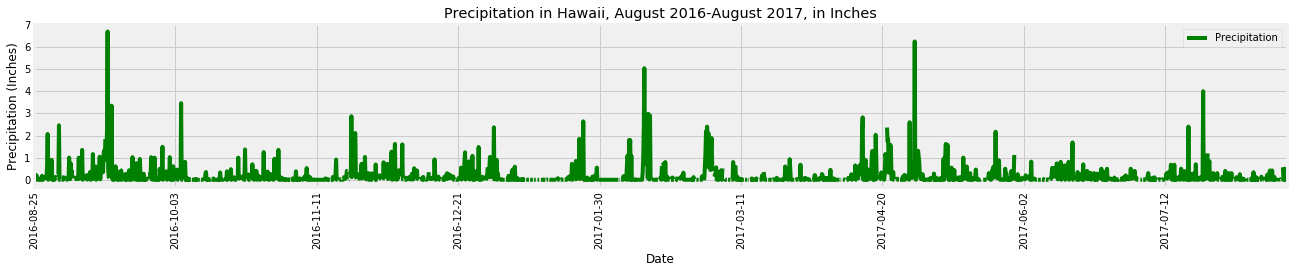

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

latest =session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
year_prior = dt.date(2017,8,23)-dt.timedelta(weeks = 52)
query_date=str(year_prior)

query=session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date > query_date).\
        order_by(Measurement.date).all()

precipitation = pd.DataFrame(query, columns = ['Date','Precipitation'])
precipitation=precipitation.set_index('Date')

precipitation.reset_index().plot(x='Date', y='Precipitation', kind='line', color='green', figsize=(20,3))

plt.xticks(rotation='vertical')
plt.title("Precipitation in Hawaii, August 2016-August 2017, in Inches")
plt.ylabel("Precipitation (Inches)")

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2009.000000
mean,0.172344
std,0.452818
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Measurement.station).\
                        group_by(Measurement.station).count()
number_of_stations

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#'id' in measurement is not the same as 'id' in station!

query = session.query(Station.id, Station.name, Measurement.station, func.count(Measurement.date)).\
                    filter(Measurement.station == Station.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.date)).all()                   

print(f'Station #{query[8][0:2]} has the most observations with {query[8][3]} in total.')
query

Station #(7, 'WAIHEE 837.5, HI US') has the most observations with 2772 in total.


[(5, 'UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511),
 (4, 'PEARL CITY, HI US', 'USC00517948', 1372),
 (8, 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 (3, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 2202),
 (9, 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 (6, 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 (2, 'KANEOHE 838.1, HI US', 'USC00513117', 2709),
 (1, 'WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 (7, 'WAIHEE 837.5, HI US', 'USC00519281', 2772)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

Max = session.query(func.max(Measurement.tobs)).filter(Measurement.station == Station.station).\
            filter(Station.id == 7).all()
Min = session.query(func.min(Measurement.tobs)).filter(Measurement.station == Station.station).\
            filter(Station.id == 7).all()
Avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == Station.station).\
            filter(Station.id == 7).all()


print(f'From Station ID 7, the highest temperature recorded is {Max}, the lowest is {Min}, and the average temperature of all records is {Avg}.')

From Station ID 7, the highest temperature recorded is [(85.0,)], the lowest is [(54.0,)], and the average temperature of all records is [(71.66378066378067,)].


Text(0.5, 0, 'Observed Temperature')

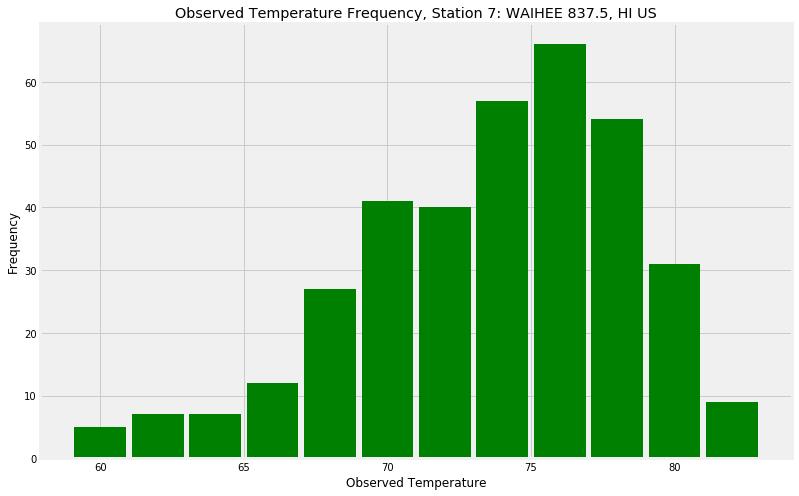

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest=session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.station == Station.station).\
            filter(Station.id == 7).\
            order_by(Measurement.date.desc()).first()

#latest date in dataset is 2017-08-18


year_prior = dt.date(2017,8,17)-dt.timedelta(weeks = 52)
query_date=str(year_prior)

query=session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == Station.station).\
        filter(Station.id == 7).\
        filter(Measurement.date > query_date).\
        order_by(Measurement.date).all()

station7 = pd.DataFrame(query, columns = ['Date','Observed Temperature'])


station7.hist(column='Observed Temperature', bins=12, figsize=(12,8), color='green', rwidth=0.9)


plt.title("Observed Temperature Frequency, Station 7: WAIHEE 837.5, HI US")
plt.ylabel("Frequency")
plt.xlabel("Observed Temperature")


In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps_daterange=calc_temps('2017-02-01', '2017-02-15')
temps_daterange

[(59.0, 69.72448979591837, 80.0)]

Text(0, 0.5, 'Temperature(F)')

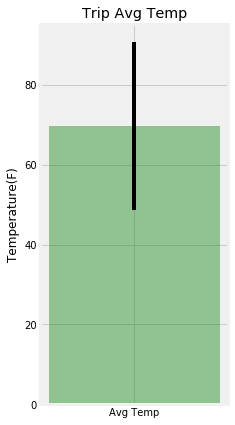

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yerr= temps_daterange[0][2]-temps_daterange[0][0]
avg = temps_daterange[0][1]

data = {'Avg Temp': avg}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(figsize=(3,7))
ax.bar(names, values, yerr=yerr, color='green', alpha=.4)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature(F)')


In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date='2017-02-01'
end_date='2017-02-15'

my_trip=session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Station.station).\
        order_by(Measurement.prcp.desc()).all()

my_trip_df = pd.DataFrame(my_trip, columns=['Station', 'Name', 'Lat', 'Lon', 'Elevation', 'Total Rainfall 2/1-2/15'])
my_trip_df

,Station,Name,Lat,Lon,Elevation,Total Rainfall 2/1-2/15
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,7.31
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,5.24
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.43
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,6.23
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,3.45
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,6.91


## Optional Challenge Assignment

# Temperature Analysis I

In [23]:
#Calculate the average temperature in June at all stations across all available years in the dataset.  
#Do the same for December temperature.
#Use a ttest to determine wheter the difference in the means, if any, is statistically signification.  
#Paired ttest, or unpaired ttest? Why?

In [24]:
#Finding the earliest year/latest year in the dataset
latest =session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
earliest =session.query(Measurement.date).\
            order_by(Measurement.date).first()
print(earliest, latest)

('2010-01-01',) ('2017-08-23',)


In [25]:
#using a 'for' loop to calculate average temperatures in June for all stations over each year

years=['2010-06', '2011-06', '2012-06', '2013-06', '2014-06', '2015-06', '2016-06', '2017-06']

june_AL=[]

for year in years:
       
    june_avg=session.query(Station.station, func.avg(Measurement.tobs)).\
        filter(Measurement.station == Station.station).\
        filter(func.strftime("%Y-%m", Measurement.date)== year).\
        group_by(Station.station).all()

    june_AL.extend(june_avg)


#june_ALL = june_AL[0] + june_AL[1] + june_AL[2] + june_AL[3] + june_AL[4] + june_AL[5] + june_AL[6] + june_AL[7] 

june_DF=pd.DataFrame(june_AL, columns=['Station', 'Avg Temperature in June'])
june_DF.head()

,Station,Avg Temperature in June
0,USC00511918,75.620690
1,USC00513117,74.800000
2,USC00514830,73.689655
3,USC00516128,72.863636
4,USC00517948,76.750000


In [26]:
#using a 'for' loop to calculate average temperatures in December for all stations over each year

years=['2010-12', '2011-12', '2012-12', '2013-12', '2014-12', '2015-12', '2016-12', '2017-12']

dec_AL=[]

for year in years:
       
    dec_avg=session.query(Station.station, func.avg(Measurement.tobs)).\
        filter(Measurement.station == Station.station).\
        filter(func.strftime("%Y-%m", Measurement.date)== year).\
        group_by(Station.station).all()

    dec_AL.extend(dec_avg)


#dec_ALL = dec_AL[0] + dec_AL[1] + dec_AL[2] + dec_AL[3] + dec_AL[4] + dec_AL[5] + dec_AL[6] + dec_AL[7] 

dec_DF=pd.DataFrame(dec_AL, columns=['Station', 'Avg Temperature in Dec'])
dec_DF.head()

,Station,Avg Temperature in Dec
0,USC00511918,70.000000
1,USC00513117,70.967742
2,USC00514830,69.233333
3,USC00516128,69.483871
4,USC00517948,69.500000


In [27]:
june_var= np.var(june_DF['Avg Temperature in June']) 
dec_var=np.var(dec_DF['Avg Temperature in Dec'])

june_var>dec_var #returns true, so June>Dec, so F value will be JuneVar/DecVar

F = june_var/dec_var
print(f'If F is close to 1, we can consider the variance as "equal".  Our F score is: {F}')

If F is close to 1, we can consider the variance as "equal".  Our F score is: 1.345766967094278


In [28]:
#T-test to determine wheter the difference in the means in statistically significant
ttest = stats.ttest_ind(june_DF['Avg Temperature in June'], dec_DF['Avg Temperature in Dec'], equal_var=True)
ttest

Ttest_indResult(statistic=9.63349589063675, pvalue=1.2859369458004907e-16)

### Results

<p> The above cell shows the F value, calculated from the variances of the December and June data sets.  I calculated this to decide which T-test I should use.  

 I know to use an "unpaired" T-test because the two datasets are independent (at least to me, the weather in December does not depend on the weather in June, it depends on the position of the earth relative to the sun, among other things).  So to use the unpaired T-test I needed to conclude if the variance is equal or not.

In running the T-test, it returns a very small 'p-value', so the difference in the means of the datasets is statistically significant.</p>

# Temperature Analysis II

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

trip_dates = ['2017-02-01', '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05', '2017-02-06', '2017-02-07', \
              '2017-02-08', '2017-02-09','2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13', '2017-02-14', '2017-02-15'] 
             
normals = []

for date in trip_dates:
    normals.extend(calc_temps(date, date))
    
normals
    

[(62.0, 68.0, 72.0),
 (59.0, 64.14285714285714, 72.0),
 (60.0, 66.0, 73.0),
 (66.0, 70.2, 76.0),
 (69.0, 74.5, 80.0),
 (73.0, 75.28571428571429, 77.0),
 (64.0, 68.28571428571429, 76.0),
 (59.0, 65.85714285714286, 74.0),
 (59.0, 63.285714285714285, 71.0),
 (62.0, 68.28571428571429, 74.0),
 (65.0, 67.83333333333333, 70.0),
 (65.0, 69.83333333333333, 76.0),
 (68.0, 74.14285714285714, 80.0),
 (72.0, 76.66666666666667, 79.0),
 (71.0, 74.57142857142857, 76.0)]

In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normalsDF = pd.DataFrame(normals, columns = ['Minimum', 'Average', 'Maximum'])
normalsDF['Date'] = trip_dates
normalsDF.set_index('Date')

,Minimum,Average,Maximum
Date,,,
2017-02-01,62.0,68.000000,72.0
2017-02-02,59.0,64.142857,72.0
2017-02-03,60.0,66.000000,73.0
2017-02-04,66.0,70.200000,76.0
2017-02-05,69.0,74.500000,80.0
2017-02-06,73.0,75.285714,77.0
2017-02-07,64.0,68.285714,76.0
2017-02-08,59.0,65.857143,74.0
2017-02-09,59.0,63.285714,71.0


Text(0.5, 1.0, 'Minimum, Average, and Maximum Temperature, 2/1/17-2/15/17')

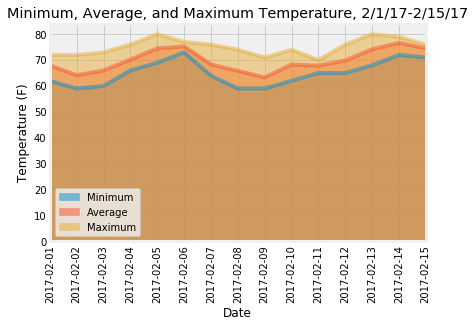

In [31]:
# Plot the daily normals as an area plot with `stacked=False`

#plt.stackplot(trip_dates, normalsDF['Minimum'], normalsDF['Average'], normalsDF['Maximum'], stacked=False)

ax = normalsDF.plot.area(stacked=False)
plt.xticks(np.arange(15), trip_dates, rotation='vertical')
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.title("Minimum, Average, and Maximum Temperature, 2/1/17-2/15/17")